**Load all the features saved as numpy array**

In [ ]:
# Load the pre-extracted image features and question embeddings.
# This retrieves the saved feature arrays from the previous steps.
# Loading these features allows us to proceed with model training without re-extracting them.

train_features = np.load("train_features.npy")  # (num_train_samples, 2048)
val_features = np.load("val_features.npy")  # (num_val_samples, 2048)

map image feature for each question row to get the same sampled dataset

In [ ]:
# Map image features to each question row based on image ID.
# This ensures that each question in the filtered DataFrames is associated with its corresponding image features.
# It handles cases where the order of questions might not match the order of extracted image features.

#Load features from filtered image IDs
train_image_features = dict(zip(df_train_filtered['image_id'], train_features)) # Create a dictionary for train features
val_image_features = dict(zip(df_val_filtered['image_id'], val_features)) # Create a dictionary for val features

# Function to get the image feature for each question row
def get_image_features_for_questions(df, image_features_dict):
    image_features = []
    for img_id in df['image_id']:
        image_features.append(image_features_dict.get(img_id, np.zeros(2048)))  # Default to zero if missing
    return np.array(image_features)

# Get the image features for the filtered train and val question rows
train_image_features_for_questions = get_image_features_for_questions(df_train_filtered, train_image_features)
val_image_features_for_questions = get_image_features_for_questions(df_val_filtered, val_image_features)

# Print out the shapes to confirm they match the number of rows
print(f"Train Image Features Shape: {train_image_features_for_questions.shape}")
print(f"Val Image Features Shape: {val_image_features_for_questions.shape}")

Train Image Features Shape: (53389, 2048)
Val Image Features Shape: (26769, 2048)


In [ ]:
train_question_embeddings = np.load("bert_embeddings_train.npy")  # (num_train_samples, 768)
train_answers = np.load("train_answers.npy")

In [ ]:
val_question_embeddings = np.load("bert_embeddings_val.npy")  # (num_val_samples, 768)
val_answers = np.load("val_answers.npy")  # (num_val_samples, 181)

# Model Architectures and training


**Approach 3: Bilinear Fusion**

Model Architecture Description (Approach 3):

This Bilinear Fusion Network builds upon the gated fusion concept by employing element-wise multiplication instead of addition for fusing the modalities. Similar to the previous approach, it starts by projecting image and text features to a common dimension (512) and applies a gating mechanism to each. However, instead of adding the gated features, it performs an element-wise multiplication, which is a form of bilinear pooling. This allows the model to capture multiplicative interactions between the visual and textual representations. An optional dense layer can be used to further project the fused features. The subsequent layers include fully connected layers with dropout and a residual connection, followed by a softmax output layer for classification.

Hyperparameters Tuned (Approach 3):

Learning Rate: Set to 0.0001 for the Adam optimizer.
Number of Epochs: Set to 10.
Batch Size: Set to 32.
Projection Dimension: Image and text features are projected to 512 dimensions.
Number of Units in Dense Layers: The dense layers after bilinear fusion use 512 units.
Dropout Rate: Set to 0.3 in the Dropout layers.

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 2048)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_input (InputLayer)   │ (None, 768)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ img_projection (Dense)    │ (None, 512)            │      1,049,088 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_projection (Dense)   │ (None, 512)            │        393,728 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gate_img (Dense)          │ (None, 512)            │        262,656 │ img_projection[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gate_text (Dense)         │ (None, 512)            │        262,656 │ text_projection[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gated_img (Multiply)      │ (None, 512)            │              0 │ img_projection[0][0],  │
│                           │                        │                │ gate_img[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gated_text (Multiply)     │ (None, 512)            │              0 │ text_projection[0][0], │
│                           │                        │                │ gate_text[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bilinear_multiply         │ (None, 512)            │              0 │ gated_img[0][0],       │
│ (Multiply)                │                        │                │ gated_text[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bilinear_proj (Dense)     │ (None, 512)            │        262,656 │ bilinear_multiply[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc1 (Dense)               │ (None, 512)            │        262,656 │ bilinear_proj[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ drop1 (Dropout)           │ (None, 512)            │              0 │ fc1[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc2 (Dense)               │ (None, 512)            │        262,656 │ drop1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual (Add)            │ (None, 512)            │              0 │ fc2[0][0], drop1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ drop2 (Dropout)           │ (None, 512)            │              0 │ residual[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 181)            │         92,853 │ drop2[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,848,949 (10.87 MB)

 Trainable params: 2,848,949 (10.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.2893 - loss: 3.3368 - val_accuracy: 0.3587 - val_loss: 2.3405
Epoch 2/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3696 - loss: 2.1532 - val_accuracy: 0.3838 - val_loss: 2.2188
Epoch 3/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4089 - loss: 1.9781 - val_accuracy: 0.4208 - val_loss: 2.0502
Epoch 4/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4290 - loss: 1.8215 - val_accuracy: 0.4425 - val_loss: 1.9231
Epoch 5/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4506 - loss: 1.7104 - val_accuracy: 0.4627 - val_loss: 1.8314
Epoch 6/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.4697 - loss: 1.6271 - val_accuracy: 0.4744 - val_loss: 1.7681
Epoch 7/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4890 - loss: 1.5544 - val_accuracy: 0.4662 - val_loss: 1.7475
Epoch 8/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5030 - loss: 1.

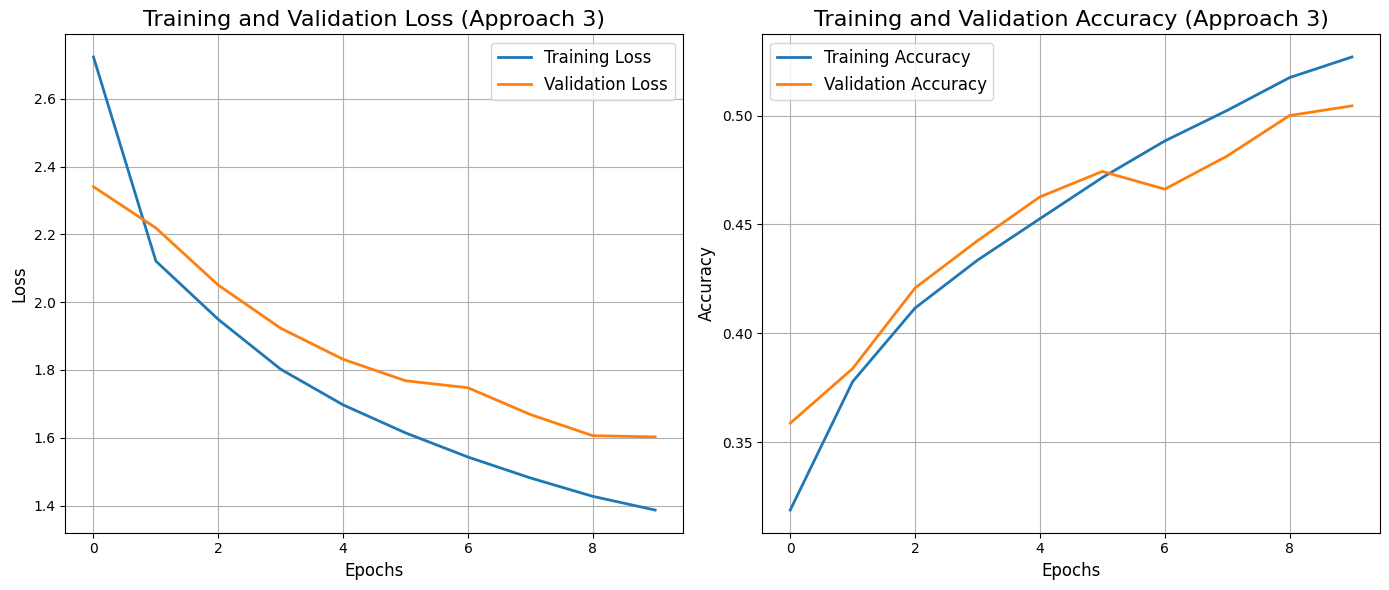

837/837 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5009 - loss: 1.7297

Approach 3 Validation Loss: 1.6024
Approach 3 Validation Accuracy: 0.5045


In [ ]:
# Define and train a Bilinear Fusion Network model.
# This model uses a bilinear operation (element-wise multiplication after gating) to fuse features.
# Bilinear fusion can capture more complex interactions between the image and text modalities compared to simple addition.

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, ReLU, Add, Multiply
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Number of answer classes (from your encoding, e.g., 181)
num_classes = 181

# 1. Define input layers for image and text features
image_input = Input(shape=(2048,), name="image_input")
text_input = Input(shape=(768,), name="text_input")

# 2. Project image features to a common hidden dimension (e.g., 512)
img_proj = Dense(512, activation='relu', name="img_projection")(image_input)
# 3. Project text features to the same hidden dimension
text_proj = Dense(512, activation='relu', name="text_projection")(text_input)

# 4. Gating mechanism
gate_img = Dense(512, activation='sigmoid', name="gate_img")(img_proj)
gate_text = Dense(512, activation='sigmoid', name="gate_text")(text_proj)
gated_img = Multiply(name="gated_img")([img_proj, gate_img])
gated_text = Multiply(name="gated_text")([text_proj, gate_text])

# 5. **Bilinear Pooling** via element-wise multiplication
#    Instead of fused_features = Add(...) from Approach #2
bilinear_fusion = Multiply(name="bilinear_multiply")([gated_img, gated_text])

# 6. Optional: Project down again (to 512) after bilinear multiplication
bilinear_proj = Dense(512, activation='relu', name="bilinear_proj")(bilinear_fusion) # (We optionally added a Dense layer (bilinear_proj) to reduce dimension after multiplication. Without this step, you might keep the dimension at 512)

# 7. Fully Connected Layers (with Residual)
fc1 = Dense(512, activation='relu', name="fc1")(bilinear_proj)
drop1 = Dropout(0.3, name="drop1")(fc1)

fc2 = Dense(512, activation='relu', name="fc2")(drop1)
residual = Add(name="residual")([fc2, drop1])  # Residual connection
drop2 = Dropout(0.3, name="drop2")(residual)

# 8. Output layer
output = Dense(num_classes, activation='softmax', name="output")(drop2)

# 9. Compile model
model_approach3 = Model(inputs=[image_input, text_input], outputs=output)
model_approach3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model_approach3.summary()

history_approach3 = model_approach3.fit(
    x=[X_train_image, X_train_text],  # separate arrays for image & text
    y=train_answers,                  # one-hot encoded answers
    validation_data=([X_val_image, X_val_text], val_answers),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Plot training and validation loss and accuracy
plt.figure(figsize=(14, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_approach3.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_approach3.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss (Approach 3)', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_approach3.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history_approach3.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy (Approach 3)', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate the model on the validation set
val_loss_approach3, val_accuracy_approach3 = model_approach3.evaluate([X_val_image, X_val_text], val_answers, verbose=1)
print(f'\nApproach 3 Validation Loss: {val_loss_approach3:.4f}')
print(f'Approach 3 Validation Accuracy: {val_accuracy_approach3:.4f}')

## **Tuned Model**

Tuned Iterations Summary
- Tanh Gating: Replaced sigmoid with tanh → Improved accuracy
- Dropout: Reduced from 0.3 → 0.2 → Lower regularization pressure
- Residual Projection: Added skip connection from bilinear input → Improved accuracy


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import TopKCategoricalAccuracy

# Hyperparameters
hidden_dim = 512
dropout_rate = 0.2
num_classes = 181

# Inputs
image_input = Input(shape=(2048,), name="image_input")
text_input = Input(shape=(768,), name="text_input")

# Projections
img_proj = Dense(hidden_dim, activation='relu')(image_input)
text_proj = Dense(hidden_dim, activation='relu')(text_input)

# Gating
# We Try tanh as a gate instead of sigmoid
gate_img = Dense(hidden_dim, activation='tanh')(img_proj)
gate_text = Dense(hidden_dim, activation='tanh')(text_proj)

gated_img = Multiply()([img_proj, gate_img])
gated_text = Multiply()([text_proj, gate_text])


# Bilinear Fusion (element-wise multiplication)
bilinear_fusion = Multiply()([gated_img, gated_text])  # Output shape: (batch, 512)

# Optional: Project fused representation again
bilinear_proj = Dense(hidden_dim, activation='relu')(bilinear_fusion)
bilinear_proj = Add()([bilinear_proj, bilinear_fusion])


# Fully Connected Layers with residual connection
fc1 = Dense(hidden_dim, activation='relu')(bilinear_proj)
fc1 = Dropout(dropout_rate)(fc1)

fc2 = Dense(hidden_dim, activation='relu')(fc1)
residual = Add()([fc2, fc1])
residual = Dropout(dropout_rate)(residual)

# Output
output = Dense(num_classes, activation='softmax')(residual)

# Model definition
model_approach3 = Model(inputs=[image_input, text_input], outputs=output)

# Compile
model_approach3.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# Train
history_approach3 = model_approach3.fit(
    x=[X_train_image, X_train_text],
    y=train_answers,
    validation_data=([X_val_image, X_val_text], val_answers),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Evaluate
val_loss_3, val_acc_3, val_top3_3 = model_approach3.evaluate([X_val_image, X_val_text], val_answers, verbose=1)
print(f"\nApproach 3 Validation Accuracy: {val_acc_3:.4f}")
print(f"Approach 3 Top-3 Accuracy: {val_top3_3:.4f}")
print(f'Approach 2 Validation Loss: {val_loss_2:.4f}')


# Plot training and validation loss and accuracy
plt.figure(figsize=(14, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_approach3.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_approach3.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss (Approach 3)', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_approach3.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history_approach3.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy (Approach 3)', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 1/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.2791 - loss: 3.6725 - top_3_accuracy: 0.5345 - val_accuracy: 0.3702 - val_loss: 2.4691 - val_top_3_accuracy: 0.6397 - learning_rate: 1.0000e-04
Epoch 2/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3713 - loss: 2.2034 - top_3_accuracy: 0.6720 - val_accuracy: 0.3885 - val_loss: 2.2201 - val_top_3_accuracy: 0.6887 - learning_rate: 1.0000e-04
Epoch 3/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4045 - loss: 1.9761 - top_3_accuracy: 0.7083 - val_accuracy: 0.4100 - val_loss: 2.1303 - val_top_3_accuracy: 0.7116 - learning_rate: 1.0000e-04
Epoch 4/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4382 - loss: 1.8284 - top_3_accuracy: 0.7343 - val_accuracy: 0.4291 - val_loss: 2.0051 - val_top_3_accuracy: 0.7259 - learning_rate: 1.0000e-04
Epoch 5/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4571 - loss: 1.7198 - top_3_accuracy: 0.7515 - val_accuracy: 0.4305 - val_loss: 1.9680 - val